# Siamese Network: **Fashion MNIST model**

### ***Model by @Om Mule***

The **Siamese Network** is a multi-input model that takes in multiple inputs using **TensorFlow & Keras Functional API** to make predictions or compare the inputs with each other.

In [26]:
# Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Lambda, Flatten, Input, Dropout
import seaborn
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import pandas as pd
import random
%matplotlib inline

## *Prepare dataset*

In [23]:
# User Defined Functions
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()
    

In [24]:
# Load Dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images/255.0
test_images = test_images/255.0

tr_pairs, tr_y = create_pairs_on_set(train_images,train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

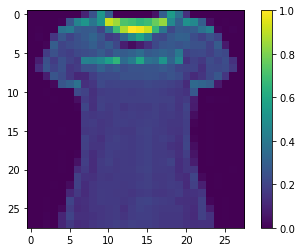

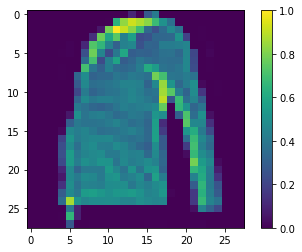

0.0


In [25]:
# View an Image
# To check, the odd numbered pairs are generally not similar whereas the even numbered are siimlar
pair = 9

show_image(ts_pairs[pair][0])
show_image(ts_pairs[pair][1])

print(ts_y[pair])

## *Modelling*

### *Initialize the Base Model*

In [28]:
# The network that is common in both parts

def initialize_base_network():
    input = Input(shape=(28,28,), name="input")
    x = Flatten(name="Flatten_input")(input)
    x = Dense(128, activation='relu', name="First_dense")(x)
    x = Dropout(0.1, name="First_Dropout")(x)
    x = Dense(128, activation='relu', name="Second_Dense")(x)
    x = Dropout(0.1, name="Second_Dropout")(x)
    x = Dense(128, activation='relu', name="Third_Dense")(x)
    
    model = Model(inputs = input, outputs = x)
    return model

In [31]:
def euclidean_dist(vecs):
    x, y = vecs
    sum_square = K.sum(K.square(x - y), axis = 1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

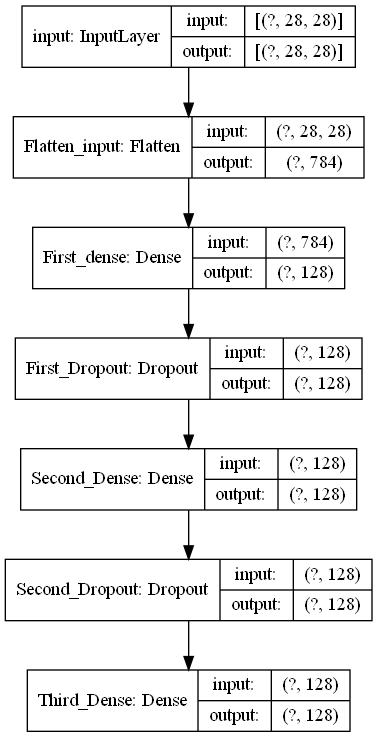

In [33]:
# Initialize the base model/network

base_network = initialize_base_network()
plot_model(base_network,show_layer_names=True, show_shapes=True, to_file= "Base-model.png")

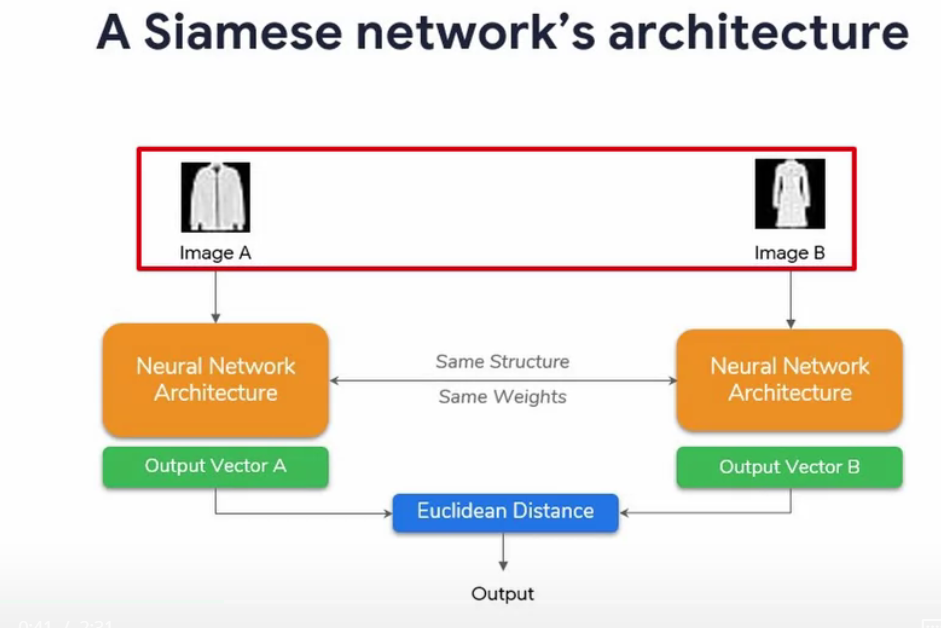

## *Siamese Network - Using Functional API*

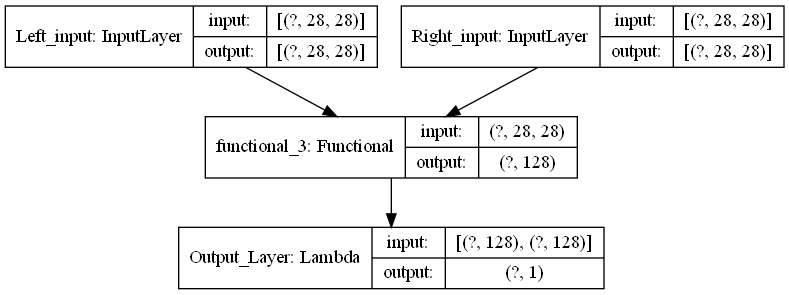

In [35]:
# Input 1
input_a = Input(shape=(28,28,), name="Left_input")
vect_output_a = base_network(input_a)

# Input 2
input_b = Input(shape=(28,28,), name="Right_input")
vect_output_b = base_network(input_b)

# Euclidean distance to measure similarity
output = Lambda(euclidean_dist, name="Output_Layer", output_shape = eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model(inputs = [input_a, input_b], outputs = output)

plot_model(model, show_layer_names=True, show_shapes=True, to_file= "Siamese-Network.png")

### *Custom Loss Function*

In [36]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [37]:
model.compile(optimizer= RMSprop(), loss=contrastive_loss_with_margin(margin=1))
history = model.fit(x= [tr_pairs[:, 0], tr_pairs[:, 1]], y= tr_y, epochs= 20, batch_size = 128, validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 10ms/step - loss: 0.1116 - val_loss: 0.0866
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0798 - val_loss: 0.0782 0s - loss: 0.07
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0713 - val_loss: 0.0689
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0664 - val_loss: 0.0702
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.0630 - val_loss: 0.0677
Epoch 6/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0611 - val_loss: 0.0699
Epoch 7/20
938/938 [==============================] - 7s 7ms/step - loss: 0.0595 - val_loss: 0.0687
Epoch 8/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0583 - val_loss: 0.0643
Epoch 9/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0570 - val_loss: 0.0656
Epoch 10/20
938/938 [==============================] - 6s 7ms/step - loss: 0.0561 -

In [38]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Left_input (InputLayer)         [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
Right_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 128)          133504      Left_input[0][0]                 
                                                                 Right_input[0][0]                
__________________________________________________________________________________________________
Output_Layer (Lambda)           (None, 1)            0           functional_3[2][0]    

In [39]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [40]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step - loss: 0.0625
Loss = 0.06249252334237099, Train Accuracy = 0.9407651275212535 Test Accuracy = 0.9133633633633633


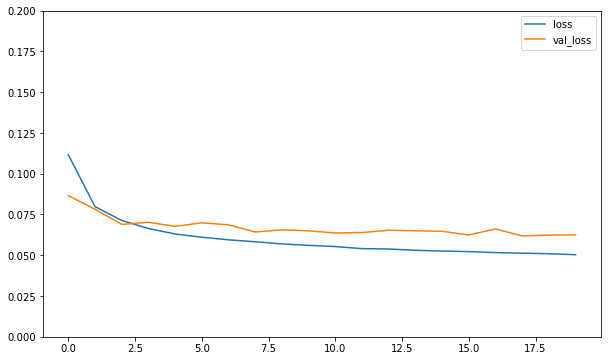

In [47]:
df = pd.DataFrame(history.history)
df.plot(figsize=(10,6))
plt.ylim(0,0.2)
plt.show()